# [Bayesian Thermostat](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) Agent-Environment Simulation

### Using [RxInfer.jl](https://rxinfer.ml/) and [RxEnvironments.jl](https://biaslab.github.io/RxEnvironments.jl/stable/)

In [1]:
using RxInfer
using RxEnvironments
using Distributions
using Plots
using Rocket
# using GLMakie

# Problem Description

This problem and agent specification is taken from [this paper](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full). 

The general setup is that we have an agent which is supposed to perform the task of a thermostat. Our agent is mobile and can perform the sole action of moving left or right along the real interval $[0, E_p]$, where $E_p > 0$ is the endpoint of the interval. The agent's only action affordance, $a_t$ will be to set its velocity at time $t$.Our agent takes a position in the interval at time $t$, given by $z_t \in [0, E_p]$. 

We suppsoe that there is a single heat source at the origin, outputing $T_0 = 100.0$ units of temperature. This heat source results in a temperature distribution on the interval, given by $T(z_t)$ which we specify below. The agent can observe a noisy measurement of the true temperature - given by $x_t$ - at its current position: $z_t$.

The agent's task is to infer the actions that result in it observing a prefered temperatrue of $x^*$, where $x^* = 4.0$. 

# Assumptions 

We assume that the environmental process consists of two things: the closed interval: $I(E_p) = [0, E_p]$, where $E_p > 0$ is the end point of the interval, and a function defined on this interval:

\begin{equation}
    T(z) = \frac{T_0}{z^2 + 1}
\end{equation}

Which specifies the temperature distribution on the interval. As mentioned above, $z_t$ is the agent's position in the environment's interval and $T_0$ is the temperature at $z_t = 0$. We will use $T_0 = 100.0$. 

The environmental process is steered by actions $a_t$ that reflect the velocity of the agent. The output of the environmental process is the observed temperature by the agent. We assume that the agent observes a noisy temperature: $x_t$, leading to the following environmental process equations:

\begin{equation}
    z_t = z_{t - 1} + a_t
\end{equation}

We also assume that the agent observes a noisy temperature:

\begin{equation}
    x_t \sim \mathcal{N}(T(z_t), \vartheta)
\end{equation}

Where we specify the following observation noise variance: $\vartheta = 10^{-2}$. 

## [Environment Specification](https://biaslab.github.io/RxEnvironments.jl/stable/lib/getting_started/#lib-started) with RxEnvironments.jl

In [2]:
"""
Models the distribution of temperature in an interval.

The origin is supposed as the only source of the temperatrue 
and source_temp is the temperature at this source. 
"""
function temperature(position, source_temp)
    return source_temp / (position^2 + 1)
end

temperature

In [3]:
mutable struct BayesianThermostatEnv
    source_temp::Float64
    interval_end_point::Float64
    interval_incr_stepsize::Float64
    temperature_distribution::Function
    interval::Vector{Float64}
    obs_noise_variance::Float64
    agent_position::Float64  # Add agent position

    # Constructor with default values
    BayesianThermostatEnv(
        source_temp::Float64 = 100.0,
        interval_end_point::Float64 = 16.0,
        interval_incr_stepsize::Float64 = 0.01,
        obs_noise_variance::Float64 = 0.7,
        agent_position::Float64 = 2.0  # Initialize at 2.0
    ) = new(
        source_temp,
        interval_end_point, 
        interval_incr_stepsize, 
        temperature, 
        collect(0.0:interval_incr_stepsize:interval_end_point),
        obs_noise_variance,
        agent_position
    )
end

In [4]:
# Helper functions
noise(
    env::BayesianThermostatEnv
) = Normal(0.0, env.obs_noise_variance)

exact_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp)

noisy_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp) + rand(noise(env))

noisy_temperature (generic function with 1 method)

## Create Instance of Env

In [6]:
env = BayesianThermostatEnv(100.0) 

BayesianThermostatEnv(100.0, 16.0, 0.01, Main.temperature, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  15.91, 15.92, 15.93, 15.94, 15.95, 15.96, 15.97, 15.98, 15.99, 16.0], 0.7, 2.0)

# Create Environment "Entity"

In [7]:
# create the env "Entity"
env_entity = create_entity(env; is_discrete = true, is_active = true)

Discrete RxEntity{BayesianThermostatEnv}

## Generate Temperature Distributions

In [8]:
# Generate temperature data
exact_temperatures = [exact_temperature(env, pos) for pos in env_entity.decorated.interval];  # Calculate exact temperatures
noisy_temperatures = [noisy_temperature(env, pos) for pos in env_entity.decorated.interval];  # Calculate noisy temperatures

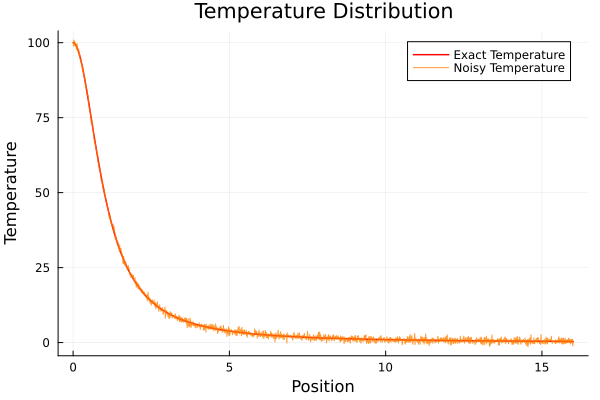

In [9]:
# a custom orange color
dark_orange = RGB(1.0, 0.5, 0.0)

# Plot exact temperatures
Plots.plot(
    env_entity.decorated.interval, 
    exact_temperatures, 
    linewidth = 1.5,
    color = "red", 
    label = "Exact Temperature", 
    title = "Temperature Distribution", 
    xlabel = "Position", 
    ylabel = "Temperature"
)

# Plot noisy temperatures
Plots.plot!(
    env_entity.decorated.interval, 
    noisy_temperatures, 
    linewidth = 1.0,
    alpha = 0.8,
    color = dark_orange, 
    label = "Noisy Temperature"
)

## [Agent Specification](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) with RxInfer.jl

Almost all of the following text was taken word-for-word from the paper listed above in the problem description.

### Generative Model:

We consider an agent with a state-space model (SSM) factorization for its internal model, given by:

\begin{equation}
    p_t(x, s, u) \propto p(s_{t-1})\prod_{k = t}^{t + T}p(x_k | s_k)p(s_k | s_{k - 1}, u_k)p(u_k)p'(x_k)
\end{equation}

where $x$, $s$, and $u$ are sequences of observations, hidden states and controls (respectively). All three of these resepctive sequences have ranges that are implicitly given by the model specification at the right-hand side. Note how the model of this Equation differs slightly from a standard SSM factorization, because it includes additional “target” priors $p'(x_k)$ over desired future outcomes. Also note that the probability distribution for the internal model has a subscript $t$ to indicate that the model is time-varying.

Also note that at time step t, the agent has assumptions about how the environment will evolve over the next $T + 1$ time steps since we can run this model forward and generate observations $x_k$ for $k = t, t + 1, …, t + T$. The horizon T is determined by the information content of the target priors $p'(x_k)$. These target priors are generally set by states of contextual processes, i.e., not by this agent but rather by other agents (or higher level processes) that encode unsurprising future outcomes for this agent. In order to distinguish the predictive model for observations $p(x_k | s_k)$ from the context-based target prior for observations $p'(x_k)$, we label the latter factor with a prime.

We refer to a sequence of future controls $u = (u_t, u_{t + 1}, ..., u_{t + T})$ as a "policy". Through inference, the posterior over policies becomes dependent on the hidden state sequence $s$. Prior to inference however, the model requires the definition of a prior belief over policies that constrains attainable control states. In a more general formulation of the internal model, we would write a prior over policies: $p(u) = p(u_t, u_{t + 1}, ..., u_{t + T})$. Here, for simplicity, we assume:

\begin{equation}
    p(u) = \prod_{k = t}^{t + T}p(u_k)
\end{equation}

### Variational Model:
Next to the internal (generative model) model, we assume that the agent has access to a variational distribution, also known as the recognition distribution:

\begin{equation}
    q_t(x, s, u)
\end{equation}

that encodes the agent's posterior beliefs about all latent states. Because the future is by definition unobserved, the recognition distribution includes the future observation variables as well. The distinction between the agent's prior (“generative”) beliefs $p_t(x, s, u)$ and posterior (“recognition”) beliefs $q_t(x,s, u)$ will be finessed below.

At the start of the simulation (say at $t = 1$), we will set $q_1$ to an uninformative distribution. As time progresses, observations become available and subsequent inference iterations will tune $q_t$ to more informed distributions. Often, but not necessarily so, the recognition distribution is assumed to be fully factorized (this is the mean-field assumption). In the present article we assume a structured factorization for the recognition distribution that is solely induced by the internal model factorization. In general, we may write:

\begin{equation}
    q_t(x, s, u) = q(x, s | u)q(u)
\end{equation}

Since actions onto the environment are real-valued interventions, we will generally enforce a deterministic posterior belief over policies, i.e.,

\begin{equation}
    q(u_t, ..., u_{t + T}) = \prod_{k = t}^{t + T} \delta(u_k - \upsilon_k)
\end{equation}

where $\upsilon_k$ (upsilon) are parameters that are to be determined in the free-energy minimization process. In other words, while the prior belief over policies $p(u)$ may contain uncertainties, we will fix the posterior belief over policies $q(u)$ on a single concrete sequence.

As time progresses, at each time step, the agent interacts with its environment through exchanging actions and observations, followed by processing the observations. Technically, everything that the agents does can be described as updates to its internal and recognition models.

### Model Specification:

#### Initial Position:
The agent shall start at position $z_0 = 2.0$ in the environmental interval. 

#### Goal Prior Model:
The agent's goal prior over observations $p'(x_k)$ encodes a belief about a preferred temperature observation. Let the agent's prefered temperature observation be denoted as $x_*$. We set agent's prefered temperature observation to be $4.0$. hence:

\begin{equation}
    p'(x_k) = \mathcal{N}(x_k | x_*, 10^{-2})
\end{equation}

#### System Dynamics Model:
Furthermore, we endow the agent with an accurate model of system dynamics:

\begin{equation}
    p(s_k | s_{k - 1}, u_k) = \mathcal{N}(s_k | s_{k - 1} + u_k, 10^{-2})
\end{equation}

#### Observation Model:
However, in order to challenge the agent, we hamper the observation model. Instead of the actual temperature profile $y_t \sim \mathcal{N}(T(z_t), \vartheta)$, we use:

\begin{equation}
    p(x_k | s_k) = \mathcal{N}(x_k | - s_k, 10^{-2})
\end{equation}

which simply specifies that the observed temperature decreases with position. This is true of course, but this is a significant "coarse-graining" of the full situation - given by the above specified temperature function: $T(z)$.  

#### Control Model and Initial State:
We specify a prior for controls:

\begin{equation}
    p(u_k) = \mathcal{N}(u_k | 0, 10^{-2})
\end{equation}

and a vague prior for the initial state:

\begin{equation}
    p(s_0) = \mathcal{N}(s_0 | 0, 10^{12})
\end{equation}

This fully defines the agent's internal model: $p_t(x, s, u)$.

## Agent Specification

In [10]:
# The agent is specified via its generative model - absent for now. 
mutable struct ThermostatAgent 
    position::Float64 # the agent's position in the interval
    infered_action::Float64 # the action that the agent has inferred 
    observed_temp::Float64

    # Constructor with default values
    ThermostatAgent(
        position::Float64 = 2.0, # initial position
        infered_action::Float64 = 0.0, # initial action is 0.0 (for no effect)
        observed_temp::Float64 = temperature(position, 100.0) + rand(Normal(0.0, 0.7))
    ) = new(
        position, 
        infered_action,
        observed_temp
    )
end

In [11]:
# place the agent at position
function reset_simulation(agent::ThermostatAgent, env::BayesianThermostatEnv, position::Float64)
    agent.position = position
    env.agent_position = position
    agent.infered_action = 0.0
end

reset_simulation (generic function with 1 method)

## Environment Entity API

In [12]:
RxEnvironments.emits(
    subject::BayesianThermostatEnv, # env
    listener::ThermostatAgent, # agent
    observation::Any
) = true # always emit an observation to the agent

RxEnvironments.what_to_send(
    recipient::ThermostatAgent, # agent
    emitter::BayesianThermostatEnv, # env
) = noisy_temperature(emitter, recipient.position)

RxEnvironments.receive!(
    recipient::BayesianThermostatEnv, # env
    emitter::ThermostatAgent,         # agent
    action::Real
) = begin
    recipient.agent_position += action
    emitter.position += action
end

RxEnvironments.update!(
    e::BayesianThermostatEnv, # env
    elapsed_time::Real
) = nothing # there is nothing to update in this static env

## Agent Entity API

This is empty in the case of the imperative main loop.

## Sensor-Motor Loop Implementation

In [13]:
agent = ThermostatAgent()

ThermostatAgent(2.0, 0.0, 19.865423672253932)

In [14]:
# add the agent entity to the environment entity:
agent_entity = add!(env_entity, agent, is_active = false) # false because inference is handled outside of RxEnvironments for now

Discrete RxEntity{ThermostatAgent}

## Checker functions:

In [15]:
function check_temp_sync(agent::ThermostatAgent, env::BayesianThermostatEnv)
    if exact_temperature(env, env.agent_position) == temperature(agent.position, 100.0) == temperature(env.agent_position, 100.0)
        return true
    end

    return false
end

check_temp_sync (generic function with 1 method)

In [16]:
function check_pos_sync(agent::ThermostatAgent, env::BayesianThermostatEnv)
    if agent.position == env.agent_position
        return true
    end

    return false
end

check_pos_sync (generic function with 1 method)

In [46]:
typeof(latest_observation)

RxEnvironments.ObservationCollection{1}

## Main Imperative Loop

In [23]:
# see generate_animation below
function run_simulation(
        env_entity::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any},
        agent_entity::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any},
        max_time::Int
    )

    reset_simulation(agent_entity.decorated, env_entity.decorated, 2.0)
    
    # Subscribe a logger actor to the observations of the agent
    RxEnvironments.subscribe_to_observations!(agent_entity, RxEnvironments.logger())

    for t in 1:max_time
        
        # Retrieve the latest observation (synchronous)
        latest_observation = noisy_temperature(env_entity.decorated, env_entity.decorated.agent_position)
        
        # Store the latest observation in the agent
        agent_entity.decorated.observed_temp = latest_observation

        # Compute the agent's action based on temperature error
        target_temp = 4.0  # Desired temperature
        # error = target_temp - latest_observation
        error = latest_observation - target_temp
        action = 0.05 * error  # Simple proportional control

        # Register the action in the agent
        agent_entity.decorated.infered_action = action

        # Send the action to the environment
        RxEnvironments.send!(
            env_entity, 
            agent_entity, 
            action
        )

        # Print debugging information
        println("\nIteration: $(t)")
        println("Agent Position: $(env_entity.decorated.agent_position)")
        println("Temperature Sync Check: $(check_temp_sync(agent_entity.decorated, env_entity.decorated))")
        println("Position Sync Check: $(check_pos_sync(agent_entity.decorated, env_entity.decorated))")
        println("Selected Action: $(action)")
        println("Observed Temperature: $(latest_observation)")
        println("True Temperature at Position: $(temperature(env_entity.decorated.agent_position, 100.0))\n")

        sleep(0.1)
    end
end

run_simulation (generic function with 1 method)

In [49]:
function generate_animation(
        env_entity::RxEnvironments.RxEntity{BayesianThermostatEnv, RxEnvironments.DiscreteEntity, RxEnvironments.ActiveEntity, Any},
        agent_entity::RxEnvironments.RxEntity{ThermostatAgent, RxEnvironments.DiscreteEntity, RxEnvironments.PassiveEntity, Any},
        max_time::Int, fps::Int, filename::String
    )

    reset_simulation(agent_entity.decorated, env_entity.decorated, 2.0)
    
    frames = @animate for t in 1:max_time
        
        # Retrieve the latest observation (synchronous)
        latest_observation = noisy_temperature(env_entity.decorated, env_entity.decorated.agent_position)
        
        # Store the latest observation in the agent
        agent_entity.decorated.observed_temp = latest_observation

        # Compute the agent's action based on temperature error
        target_temp = 4.0  # Desired temperature
        # error = target_temp - latest_observation
        error = latest_observation - target_temp
        action = 0.05 * error  # Simple proportional control

        # Register the action in the agent
        agent_entity.decorated.infered_action = action

        # Send the action to the environment
        RxEnvironments.send!(
            env_entity, 
            agent_entity, 
            action
        )

        # Plot temperature distribution
        x = 0:0.1:env_entity.decorated.interval_end_point
        y = temperature.(x, env_entity.decorated.source_temp)
        plot(x, y, label = "Temperature Distribution", xlabel = "Position", ylabel = "Temperature", legend = :topright)

        # Plot agent's position
        # scatter!([agent_entity.decorated.position], [temperature(agent_entity.decorated.position, env_entity.decorated.source_temp)], label="Agent Position", color=:red)
        scatter!([agent_entity.decorated.position], [5], label = "Agent Position", color = :red)

        # Print debugging information
        println("\nIteration: $(t)")
        println("Agent Position: $(env_entity.decorated.agent_position)")
        println("Temperature Sync Check: $(check_temp_sync(agent_entity.decorated, env_entity.decorated))")
        println("Position Sync Check: $(check_pos_sync(agent_entity.decorated, env_entity.decorated))")
        println("Selected Action: $(action)")
        println("Observed Temperature: $(latest_observation)")
        println("True Temperature at Position: $(temperature(env_entity.decorated.agent_position, 100.0))\n")

        sleep(0.1)

        # Add title
        title!("Time Step: $t")
    end

    # Save the animation as a GIF
    gif(frames, filename, fps = fps)
end

generate_animation (generic function with 1 method)

[LogActor] Data: 11.337736209562483
[LogActor] Data: 11.337736209562483
[LogActor] Data: 11.337736209562483
[LogActor] Data: 11.337736209562483
[LogActor] Data: 11.337736209562483

Iteration: 1
Agent Position: 2.84273688390703
Temperature Sync Check: true
Position Sync Check: true
Selected Action: 0.8427368839070302
Observed Temperature: 20.8547376781406
True Temperature at Position: 11.011817563003829

[LogActor] Data: 7.95375994712075
[LogActor] Data: 7.95375994712075
[LogActor] Data: 7.95375994712075
[LogActor] Data: 7.95375994712075
[LogActor] Data: 7.95375994712075

Iteration: 2
Agent Position: 3.2347994048178896
Temperature Sync Check: true
Position Sync Check: true
Selected Action: 0.39206252091085947
Observed Temperature: 11.84125041821719
True Temperature at Position: 8.7230142295718

[LogActor] Data: 9.228464807918325
[LogActor] Data: 9.228464807918325
[LogActor] Data: 9.228464807918325
[LogActor] Data: 9.228464807918325
[LogActor] Data: 9.228464807918325

Iteration: 3
Agent 

[ Info: Saved animation to /home/fraserp/Desktop/Resources/Active_Inference_Institute/RxInfer_Group/RxEnvironments/agent_motion.gif


Plots.AnimatedGif("/home/fraserp/Desktop/Resources/Active_Inference_Institute/RxInfer_Group/RxEnvironments/agent_motion.gif")
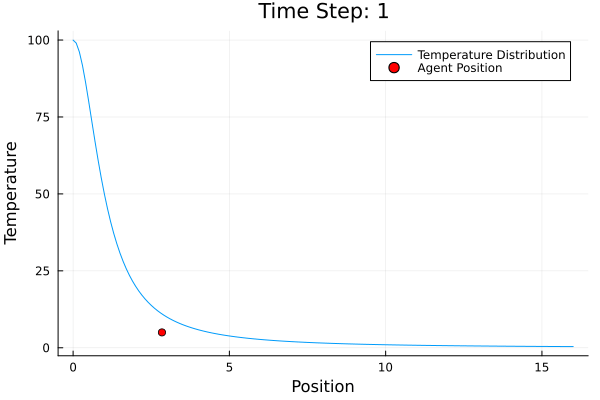

In [51]:
generate_animation(env_entity, agent_entity, 100, 10, "agent_motion.gif")